In [1]:
import unicodedata
import string
import re
import random
import time
import math
import jieba
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
USE_CUDA = torch.cuda.is_available()
print('USE_CUDA: %s' % USE_CUDA)
SEGMENTATION = True    # 是否分词

USE_CUDA: True


In [3]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u4e00-\u9fa5.!?，。？]+", r" ", s)
    return s

In [4]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang(object):
    """
    词表Vocabulary.
    """

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", '2': 'UNK'}
        self.n_words = 3 # Count SOS and EOS
      
    def index_words(self, sentence):
        if self.name == 'cn':
            words = list(jieba.cut(sentence)) if SEGMENTATION else sentence    
            for word in words:
                self.index_word(word)
        else:
            words = sentence.split(' ')
            for word in words:
                self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10

def filter_pair(p):
    return len(p[1].split(' ')) < MAX_LENGTH

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('cn', 'eng', False)

# Print an example pair
print(random.choice(pairs))

Reading lines...


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Read 90000 sentence pairs
Trimmed to 68898 sentence pairs
Indexing words...


Loading model cost 0.597 seconds.
Prefix dict has been built successfully.


['我会出席会议的。', 'i will be at the meeting .']


In [8]:
def sample_test_dataset(size=100):

    with open('cn-eng-test.txt', 'w+') as f:
        f.write('\n'.join(['\t'.join(pair) for pair in random.sample(pairs, k=size)]))

In [9]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    """
    根据词表，将句子转化成索引列表。

    :reutrn list，e.g. [1, 2, 3, 4]
    """
    if lang.name == 'cn':
        words = list(jieba.cut(sentence)) if SEGMENTATION else sentence
        return [lang.word2index[word] if word in lang.word2index else UNK_token for word in words ]
    else:
        words = sentence.split(' ')
        return [lang.word2index[word] if word in lang.word2index else UNK_token for word in words]

def variable_from_sentence(lang, sentence):
    """
    将句子转换成Tensor.
    
    :return Tensor, shape(n, 1)
    """
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = torch.LongTensor(indexes).view(-1, 1)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    """
    将平行语料对转化成Tensors.
    
    :return (input_tensor, output_tensor)
    """
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [10]:
pair = random.choice(pairs)
print('pair: %s' % pair)

input_tensor, target_tensor = variables_from_pair(pair)
print('input_tensor shape: %s, output_tensor shap: %s' % (input_tensor.shape, target_tensor.shape))
print('input_tensor: %s' % input_tensor)

pair: ['你早點回來，行嗎？', 'you come back soon ok ?']
input_tensor shape: torch.Size([8, 1]), output_tensor shap: torch.Size([7, 1])
input_tensor: tensor([[  13],
        [1238],
        [  29],
        [  21],
        [2911],
        [ 538],
        [  17],
        [   1]], device='cuda:0')


In [11]:
class EncoderGRU(nn.Module):
    """GRU 编码器"""

    def __init__(self, input_size, hidden_size, n_layers=1, bidirectional=False):
        """
        初始化
        :param input_size, 输入词表大
        :param hidden_size, Embedding维度大小，RNN hidden大小
        :param n_layers, RNN层数
        """
        super(EncoderGRU, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # 用GRU替换RNN
        # self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        """
        前向传播
        :param word_inputs, 输入序列 shape(n, 1)
        :param hidden, 隐层 shape(seq_len*n_layers, batch_size, hidden_size)
        :return output(seq_len, batch, num_directions*hidden_size),
                hidden(num_layers*num_directions, hidden_size)
        """
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        num_directions = 2 if self.bidirectional else 1
        hidden = torch.zeros(self.n_layers*num_directions, 1, self.hidden_size)
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [12]:
class Attention(nn.Module):
    # BahdanauAttention
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        """
        前向传播
        :param decoder_hidden: shape(num_layers*num_directions, batch, hidden_size)
        :param encoder_outputs: shape(seq_len, batch, num_directions*hidden_size)
        :return attention_weighted_encoder_output shape(num_layers, batch, hidden_size)
        """
        query = decoder_hidden[-1]  # 只取decoder最后一层的隐藏状态
        query = query.unsqueeze(1)  # 增加维度以便与encoder_outputs相加
        energy = torch.tanh(self.W(query) + self.U(encoder_outputs))
        attention = F.softmax(self.v(energy), dim=0)
        context = attention * encoder_outputs
        attn_output = torch.sum(context, dim=0)
        return attn_output.view(1, 1, -1)

In [13]:
class DecoderGRU(nn.Module):
    """注意力机制解码器"""

    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(DecoderGRU, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.attention = Attention(hidden_size)
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)

        # 使用GRU替换RNN
        # self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size*2, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time        
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        rnn_output, hidden = self.rnn(word_embedded, last_hidden)
        rnn_output = rnn_output.squeeze(0)

        # attention weighted encoder output
        attn_weighted_encoder_output = self.attention(hidden, encoder_outputs)
        attn_weighted_encoder_output = attn_weighted_encoder_output.squeeze(0)
        
        concat_output = torch.cat([rnn_output, attn_weighted_encoder_output], dim=1)
        output = F.log_softmax(self.out(concat_output))

        return output, hidden

In [14]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, 
          encoder, decoder, 
          encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = torch.LongTensor([[SOS_token]])
    # Use last hidden state from encoder to start decoder
    decoder_hidden = encoder_hidden
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = torch.LongTensor([[ni]]) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [15]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [16]:
hidden_size = 500
n_layers = 1
dropout_p = 0.05
n_epochs = 150000

# Initialize models
encoder = EncoderGRU(input_lang.n_words, hidden_size, n_layers)
decoder = DecoderGRU(hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# Configuring training
plot_every = 200
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, 
                 encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = 'Epoch %d/%d, %s, %.4f' % (epoch, n_epochs, time_since(start, epoch / n_epochs), 
                                                   print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0.05

/root/miniconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/tmp/ipykernel_2839/3848772925.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(concat_output))
/tmp/ipykernel_2839/3644649550.py:57: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
/tmp/ipykernel_2839/3644649550.py:58: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)


Epoch 1000/150000, 0m 15s (- 37m 40s), 4.9200
Epoch 2000/150000, 0m 30s (- 37m 54s), 4.5888
Epoch 3000/150000, 0m 46s (- 38m 12s), 4.4243
Epoch 4000/150000, 1m 3s (- 38m 52s), 4.2580
Epoch 5000/150000, 1m 28s (- 42m 53s), 4.2194
Epoch 6000/150000, 1m 52s (- 45m 4s), 4.1849
Epoch 7000/150000, 2m 17s (- 46m 46s), 4.0790
Epoch 8000/150000, 2m 42s (- 48m 5s), 4.0197
Epoch 9000/150000, 3m 6s (- 48m 42s), 3.9448
Epoch 10000/150000, 3m 30s (- 49m 4s), 3.9106
Epoch 11000/150000, 3m 54s (- 49m 21s), 3.8593
Epoch 12000/150000, 4m 18s (- 49m 32s), 3.8151
Epoch 13000/150000, 4m 42s (- 49m 41s), 3.7843
Epoch 14000/150000, 5m 6s (- 49m 41s), 3.7578
Epoch 15000/150000, 5m 31s (- 49m 39s), 3.6588
Epoch 16000/150000, 5m 55s (- 49m 33s), 3.6501
Epoch 17000/150000, 6m 19s (- 49m 29s), 3.6408
Epoch 18000/150000, 6m 43s (- 49m 22s), 3.5317
Epoch 19000/150000, 7m 7s (- 49m 9s), 3.5419
Epoch 20000/150000, 7m 31s (- 48m 55s), 3.4147
Epoch 21000/150000, 7m 55s (- 48m 42s), 3.4810
Epoch 22000/150000, 8m 20s (- 

<Figure size 432x288 with 0 Axes>

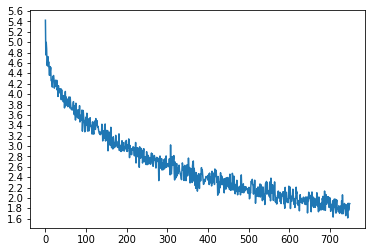

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [18]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = torch.LongTensor([[SOS_token]]) # SOS
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])
            
        # Next input is chosen word
        decoder_input = torch.LongTensor([[ni]])
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words

In [19]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [20]:
evaluate_randomly()

> 那个日文词汇没有对应的英文。
= that japanese word has no equivalent in english .
< that japanese japanese has no no in without english .



/tmp/ipykernel_2839/3848772925.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(concat_output))


In [21]:
' '.join(evaluate('人生是有趣的。'))

/tmp/ipykernel_2839/3848772925.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(concat_output))


'life is fun . <EOS>'

In [22]:
import collections
from torchtext.data.metrics import bleu_score


# 读取测试数据集
with open('cn-eng-test.txt') as f:
    lines = f.read().strip().split('\n')
    
    test_pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]



test_pairs_dict = collections.defaultdict(lambda : [])

for pair in test_pairs:
    test_pairs_dict[pair[0]].append(pair[1].split(' '))


def evaluate_bleu_score():
    candicates = []
    references = []

    for i, pair in enumerate(test_pairs_dict.items(), start=1):
        candicate = evaluate(pair[0])
        if candicate[-1] == '<EOS>':
            candicate.pop(-1)
        candicates.append(candicate)
        references.append(pair[1])
    
    score = bleu_score(candicates, references)
    return score

In [23]:
print('test dataset bleu score: %s' % evaluate_bleu_score())

/tmp/ipykernel_2839/3848772925.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(concat_output))


test dataset bleu score: 0.3768230140101369


In [24]:
def predict(filepath):
    """预测"""
    with open('test.txt') as f:
        sentences =  [line.strip() for line in f.readlines()]

    output_sentences = []
    for sentence in sentences:
        output_sentence = ' '.join(evaluate(sentence))
        output_sentences.append(output_sentence.strip('<EOS>'))
    
    with open(filepath, 'w') as f:
        f.write('\n'.join(output_sentences))

In [25]:
predict('result-attention.txt')

/tmp/ipykernel_2839/3848772925.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(concat_output))
